# Hypothesis 5: "Higher population density means higher transmission rate"

  - H0: Higher population density does not affect the transmission rate

  - H1: Higher population density increases the transmission rate

  - H2: Higher population density decreases the transmission rate

## Introduction
At beginning of July, Texas saw a surge in COVID-19 cases. The class' initial analysis, which was performed on a subset of Texas counties, saw that some counties that had a large population density were more affected than counties with smaller population density. This hypothesis was created to investigate if there is a possible relationship between population density and the rate of transmission of COVID-19. 

In [1]:
# Loading the packages required for analysis and visualization
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches
from scipy.stats.stats import pearsonr
from scipy.stats import linregress
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import re

# Downloading population data 
!rm pop.csv
!wget --no-check-certificate https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/Population_density.csv -O pop.csv

# Install Basemap package
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install -U git+https://github.com/matplotlib/basemap.git
#Loading Basemap package
from mpl_toolkits.basemap import Basemap

# Downloading County geographic data
!rm counties* County.*
!wget https://opendata.arcgis.com/datasets/9b2eb7d232584572ad53bad41c76b04d_0.zip -O counties.zip
!unzip counties.zip


rm: cannot remove 'pop.csv': No such file or directory
--2020-10-01 19:18:28--  https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/Population_density.csv
Resolving gitlab.tamucc.edu (gitlab.tamucc.edu)... 64.71.82.39
Connecting to gitlab.tamucc.edu (gitlab.tamucc.edu)|64.71.82.39|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 8189 (8.0K) [text/plain]
Saving to: ‘pop.csv’

pop.csv             100%[===================>]   8.00K  --.-KB/s    in 0s      

2020-10-01 19:18:28 (93.7 MB/s) - ‘pop.csv’ saved [8189/8189]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
 

rm: cannot remove 'counties*': No such file or directory
rm: cannot remove 'County.*': No such file or directory
--2020-10-01 19:19:44--  https://opendata.arcgis.com/datasets/9b2eb7d232584572ad53bad41c76b04d_0.zip
Resolving opendata.arcgis.com (opendata.arcgis.com)... 52.45.166.77, 50.19.49.12, 34.198.223.29, ...
Connecting to opendata.arcgis.com (opendata.arcgis.com)|52.45.166.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘counties.zip’

counties.zip            [   <=>              ]   7.38M  14.3MB/s    in 0.5s    

2020-10-01 19:19:45 (14.3 MB/s) - ‘counties.zip’ saved [7734233]

Archive:  counties.zip
  inflating: County.shx              
  inflating: County.shp              
  inflating: County.dbf              
 extracting: County.cpg              
  inflating: County.prj              


## Data Cleaners
Datacleaner class - Parent abstract class. It defines the foundational functionality that each child should have.

Casecleaner class - Defines how to clean the COVID-19 Cumulative case data from DSHS.

Popcleaner class - Defines how to prepare the clean data from Population_density.csv to be placed in a pandas dataframe for my purposes.

In [2]:
#**********************************
# Datacleaner Class
# -----------------
#
# This class is an abstract parent class. It will form the basis for children class that have a 
# specified clean_data method
#
# Members:
# -----------------
# fp            str     the path to the datafile
# unclean_data  None    the unclean data from the specified datafile
# unclean_data  None    the cleaned data 
#
# Methods:
# -----------------
# read_data                will read data into unclean_data from a variety of file types like xlsx, csv, json
# write_unclean_data       will write the unclean data to a file of a specified filetype
# write_clean_data         will write the clean data to a file of a specified filetype
# get_fp                   a getter for the fp member
# set_fp                   a setter for the fp member
# get_unclean_data         a getter for the unclean_data member
# get_clean_data           a getter for the clean_data member
# clean_data               an abstract method. The children of the class will specify the definition of the member
#**********************************
class Datacleaner():
    #**********************************
    # Datacleaner Constructor
    #
    # Inilitized memebers:
    # --------------------
    # fp            str     should be the path to the datafile. can either be URL or OS filepath
    # unclean_data  None    This member is only created. No data
    # unclean_data  None    This member is only created. No data
    #**********************************
    def __init__(self, path=""):
        self.fp = path #path can be an OS file path or url
        self.unclean_data = None
        self.clean_data = None
    #**********************************
    # read_data method
    #
    # Uses a file path, either URL or OS filepath, to read and create a Pandas dataframe of the data.
    #
    # Parameters:
    # --------------------
    # filetype        str     the filetype of the datafile that is being read
    # sheetname       str     for xls or xlsx filetypes. to specify which sheet to read data from.
    # orientation     str     for json filetype. to specify the format the JSON is in. The expected values are 'split', 
    #                         'records', 'index', 'columns', 'values', 'tables'. for more info: 
    #                         https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html
    # skip            int     number of rows to be skipped from being read
    # b               int     the 'before' row to truncate the dataframe
    # a               int     the 'after' row to truncate the dataframe
    # delim           str     for csv filetype. the char or str that separates the values in a csv file
    # missing_values  list    used for specifying missing values that pandas can't automatically detect. place each 
    #                         missing value str into a list and place the list to the missing_values parameter.
    #**********************************
    def read_data(self, filetype, sheetname='', orientation='', skip=0, b=0, a=253, delim = '', missing_values = ["--", "-"]):
        if not self.fp:
            return 'Error: No file path or URL has been specified'
        
        if filetype.lower() == 'xlsx' or filetype.lower() == 'xls':
            if not sheetname:
                return "Error: No sheet name has been given"
            self.unclean_data = pd.read_excel(self.fp, sheet_name=sheetname, na_values = missing_values, skiprows=skip)
        elif filetype.lower() == 'csv':
            if not delim:
                return "Error: No delimiter has been given"
            self.unclean_data = pd.read_csv(self.fp, delimiter = delim, na_values = missing_values, skiprows=skip)
        elif filetype.lower() == 'json':
            if not orientation:
                return "Error: No orientation has been given"
            self.unclean_data = pd.read_json(self.fp, orient=orientation, na_values = missing_values)
        else:
            return "Error: No data was read"
        
        if self.unclean_data is not None:
            self.unclean_data = self.unclean_data.truncate(before = b, after = a)
        
        return None
    #**********************************
    #
    #
    #**********************************
    def write_unclean_data(self, filetype, filepath):
        if not filepath:
            return 'Error: No file path or URL has been specified'
        
        if filetype.lower() == 'xlsx' or filetype.lower() == 'xls':
            self.unclean_data.to_excel(filepath, index = False)
        elif filetype.lower() == 'csv':
            self.unclean_data.to_csv(filepath)
        elif filetype.lower() == 'json':
            self.unclean_data.to_json(filepath)
        else:
            return "Error: filetype not supported"
    #**********************************
    #
    #
    #**********************************
    def write_clean_data(self, filetype, filepath):
        if not filepath:
            return 'Error: No file path or URL has been specified'
        
        if filetype.lower() == 'xlsx' or filetype.lower() == 'xls':
            self.clean_data.to_excel(filepath, index = False)
        elif filetype.lower() == 'csv':
            self.clean_data.to_csv(filepath)
        elif filetype.lower() == 'json':
            self.clean_data.to_json(filepath)
        else:
            return "Error: filetype not supported"
    #**********************************
    #
    #
    #**********************************
    def set_fp(self, path):
        self.fp = path
    #**********************************
    #
    #
    #**********************************
    def get_fp(self):
        return "Path to the file: {}".format(self.fp)
    #**********************************
    #
    #
    #**********************************
    def get_unclean_data(self):
        return self.unclean_data.copy()
    #**********************************
    #
    #
    #**********************************
    def get_clean_data(self):
        return self.clean_data.copy()
    #**********************************
    #
    #
    #**********************************
    def cleaning_data(self):
        pass

#**********************************
#
#
#**********************************
class Casecleaner(Datacleaner):
  def __init__(self, path=""):
        super().__init__(path)
        
  def cleaning_data(self):
    self.clean_data = self.unclean_data.copy()
    self.clean_data = self.clean_data.set_index("County Name")
    self.clean_data = self.clean_data.set_index(self.clean_data.index.str.lower())
    pattern = re.compile('[0-9]+-[0-9]+', re.IGNORECASE)
    datesCase = [dt.datetime.strptime(pattern.findall(sub)[0], '%m-%d') for sub in self.clean_data.keys()]
    self.clean_data.columns = [pattern.findall(sub)[0] for sub in self.clean_data.keys()]
    # Add mean row
    #mean = self.clean_data.mean()
    #total = self.clean_data.sum()
    #self.clean_data.loc[-1] = mean
    #idx = self.clean_data.index.tolist()
    #idx[-1] = "mean"
    #self.clean_data.index = idx
    # Add total row
    #self.clean_data.loc[-1] = total
    #idx = self.clean_data.index.tolist()
    #idx[-1] = "total"
    #self.clean_data.index = idx

#**********************************
#
#
#**********************************
class Popcleaner(Datacleaner):
  def __init__(self, path=""):
    super().__init__(path)
  
  def cleaning_data(self):
    self.clean_data = self.unclean_data.copy()
    self.clean_data = self.clean_data.replace(',','', regex=True)
    self.clean_data['Name'] = self.clean_data['Name'].str.lower()
    self.clean_data = self.clean_data.set_index('Name')
    self.clean_data = self.clean_data.apply(pd.to_numeric,errors='coerce')

## Data
**COVID-19 Cumaltive Cases Data** - The hypothesis is looking into what happens with population density and the rate of transmission, however there is not a clear way to determine the exact rate of transmission (ROT) of COVID-19. To approximate the rate of transmission, the infection case numbers of COVID-19 will be use. This does make sense because there is a relationship between ROT and infection cases. The source of the infection cases is the Texas DSHS: https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyCaseCountData.xlsx

**Texas Counties' Population Data** - Population data is integral to this hypothesis. The last complete and accurate survey of Texas' counties' population is the 2010 census. The source of the population data is texascounties.net: http://www.texascounties.net/statistics/popdensity2010.htm

In [3]:
cases_dc = Casecleaner('https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyCaseCountData.xlsx')
cases_dc.get_fp()
cases_dc.read_data(filetype='xlsx', sheetname="Cases by County", skip=2, b=0, a=253)
cases_dc.cleaning_data()

In [4]:
pop_dc = Popcleaner('pop.csv')
pop_dc.get_fp()
pop_dc.read_data(filetype='csv', delim=',', skip=0)
pop_dc.cleaning_data()

## Grouping Counties based on Population Density
This will be used later for visualization.

In [5]:
dfpop = pop_dc.get_clean_data()
dfcases = cases_dc.get_clean_data()

dfpop = dfpop.drop('Rank', 1)
dfpop = dfpop.drop('Land Area(mi2)', 1)
dfpop = dfpop.rename({'PopulationDensity ( /mi2)':'PD', 'Population2010':'POP'}, axis=1)

grouping = [0,0.2,0.4,0.6,0.8,1]
classlabels = ['A', 'B', 'C', 'D', 'E']

bins, binedges = pd.qcut(dfpop['PD'],q=grouping, labels=classlabels, retbins=True)
dfpop['Class'] = bins
print(bins)


Name
dallas      E
harris      E
tarrant     E
bexar       E
travis      E
           ..
mcmullen    A
terrell     A
king        A
kenedy      A
loving      A
Name: PD, Length: 254, dtype: category
Categories (5, object): ['A' < 'B' < 'C' < 'D' < 'E']


## Computing the ROT approximations
It is important to understand what ROT is. ROT is the rate at which a virus infects people in a given population. How is that calculated?

ROT was assume to have this form: ROT = Sum[ P(Getting Infected | Contacting an infected person) * # of effective contacts] over a heterogenous population.

Breakdown:
  - What is meant by effective contacts? For COVID-19, it is a person coming within ~6ft of another person and breathing the same air.
  - How to calculate the effective contacts? Probably through a mixture of population data like population density, travel data, how many people are following COVID guidelines, etc.
    - Since the Hypothesis focuses on PD, travel data and etc was excluded.
  - How is the P(Getting Infected | Contacting an infected person) calculated? The probability can be calculate through Bayesian methods, but this requires lots of data. Also calculating this probability is not the objective of the hypothesis. Thus this probability was not calculated. So how was ROT determined? 
  - ROT was approximated using:
    - Total Cases -> ROT * Pop * Time (Only describes aftermath not how fast the virus spreads)
    - Mean Daily Case Change -> Average[ d(ROT * Pop) / dt ] (Better describes how fast the virus is spreading. The daily change has sharp increases and decreases which is not representative of ROT. Thus these increases and decreases were mitigated through cummax and averaging. However averaging also incoporates periods of artifical flattening (public health measures) of ROT)
    - Mean Weekly Case Change -> Average[ d(ROT * Pop) / dt ] (Similar to Mean Daily but incoporates a sliding window to further mitigate sharp increases and decrease to better represent ROT. However averaging still incoporates artifical flattening. 
    - Max Daily Case Change -> Instead of averaging the daily case change over the entire period of the pandemic which includes periods of artifical flattening of ROT, use the point where the virus is spreading unencumbered. That point should be the maximum value of the daily case change. Still has unrepresentative sharp increases.
    - Max Weekly Case Change -> Similar to Max Daily Case Change except a sliding window is applied the daily case change to smooth any sharp changes. 

In [20]:
dfcases = cases_dc.get_clean_data()
dfcases_T = dfcases.copy().T
#daily change
dfcasesD_T = dfcases.copy().T
dfcasesD_T = dfcasesD_T.cummax()
#weekly average change
dfcasesW_T = dfcases.copy().T
dfcasesW_T = dfcasesW_T.cummax()

#print(dfcases)

pop = dfpop['POP']

#calculating total cases per captia
for county in dfcases_T.keys():
  dfcases_T[county] = (dfcases_T[county]/float(pop[county])) * 1000

#calulating the daily change per captia
for county in dfcasesD_T.keys():
  dfcasesD_T[county] = dfcasesD_T[county].diff()
  dfcasesD_T[county] = (dfcasesD_T[county]/float(pop[county])) * 1000

#calulating the weekly change per captia
for county in dfcasesW_T.keys():
  dfcasesW_T[county] = dfcasesW_T[county].diff().rolling(window=7).mean()
  dfcasesW_T[county] = (dfcasesW_T[county]/float(pop[county])) * 1000

#creating a new dataframe to contain popdensity and mean/max daily change and mean/max weekly change
dfcounties = dfpop.copy()

dfcounties['total'] = dfcases_T.iloc[-1]
dfcounties['dmean'] = dfcasesD_T.mean()
dfcounties['dmax'] = dfcasesD_T.max()
dfcounties['wmean'] = dfcasesW_T.mean()
dfcounties['wmax'] = dfcasesW_T.max()


## Plotting Case data for each population density group 
Scatter plots were used to plot the PD and ROT assumption data. A trendline was created to demonstrate the correlation relationship between PD adn the ROT assumptions.
- Plot#1: Total Cases per 1000 capita
- Plot#2: Mean Daily Case Change per 1000 capita
- Plot#3: Mean Weekly Case Change per 1000 capita
- Plot#4: Maximum Daily Case Change per 1000 capita
- Plot#5: Maximum Weekly Case Change per 1000 capita

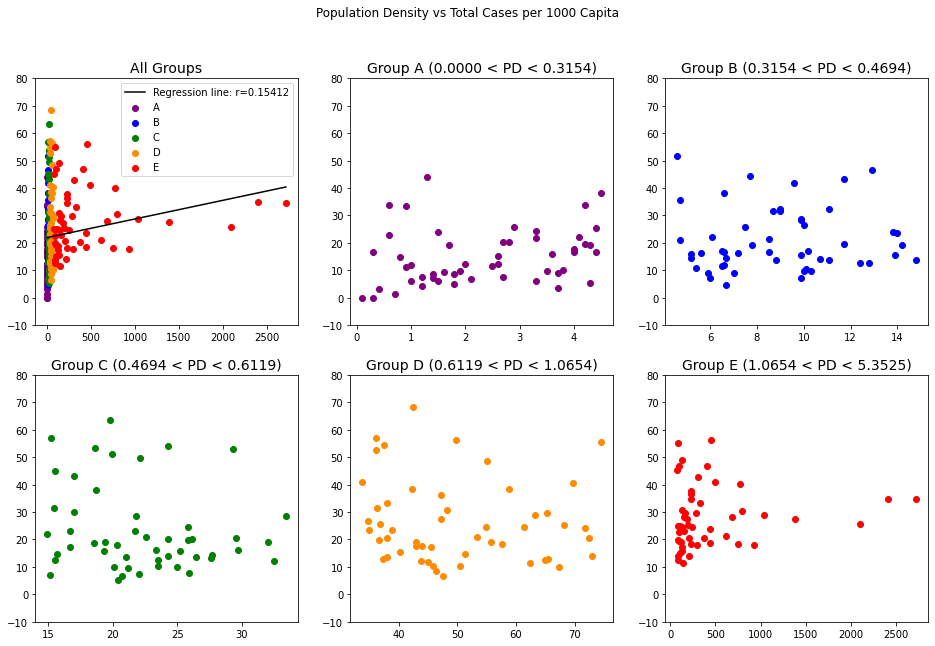

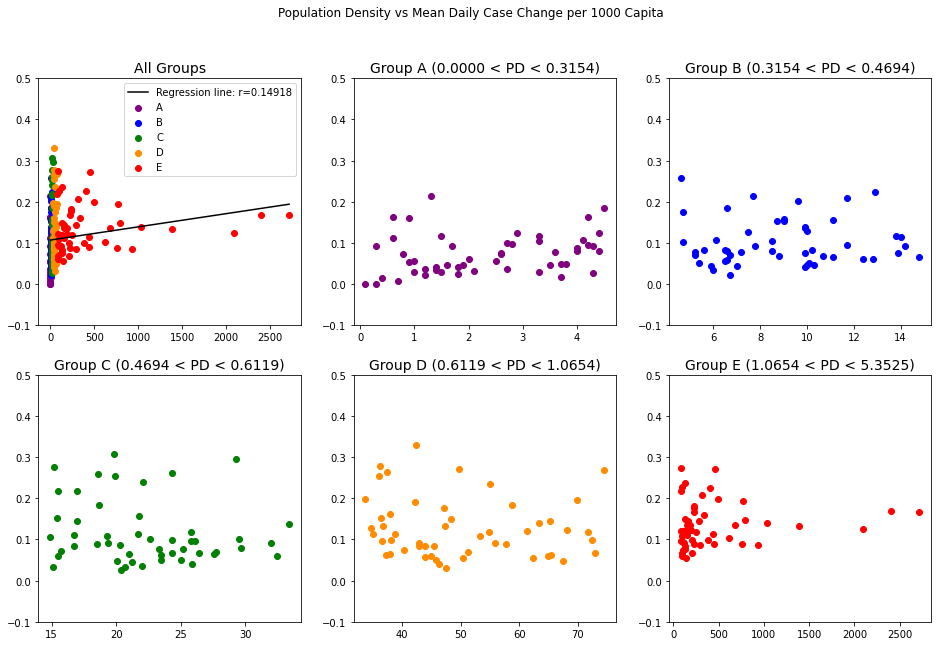

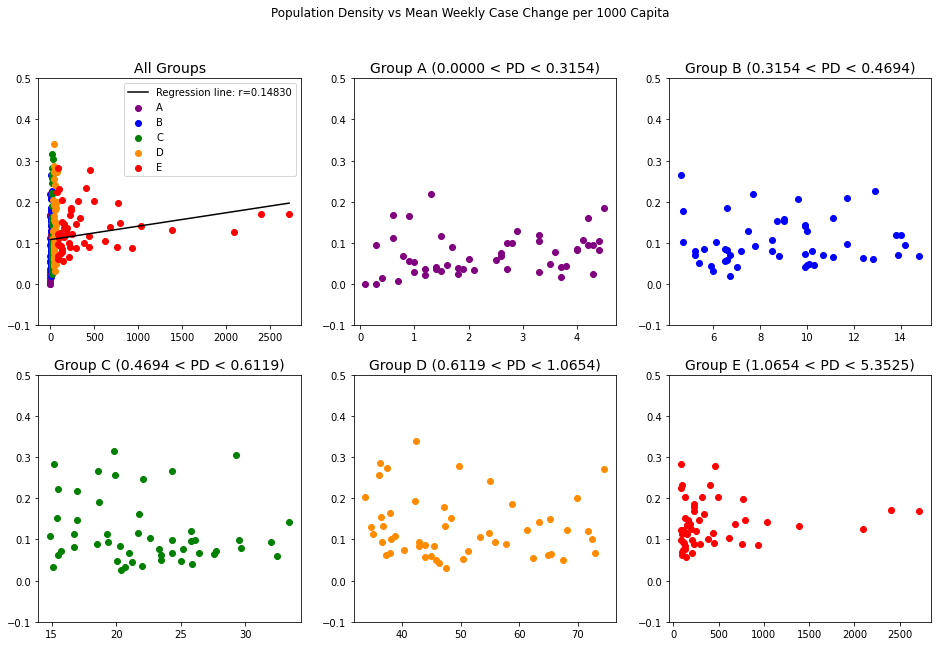

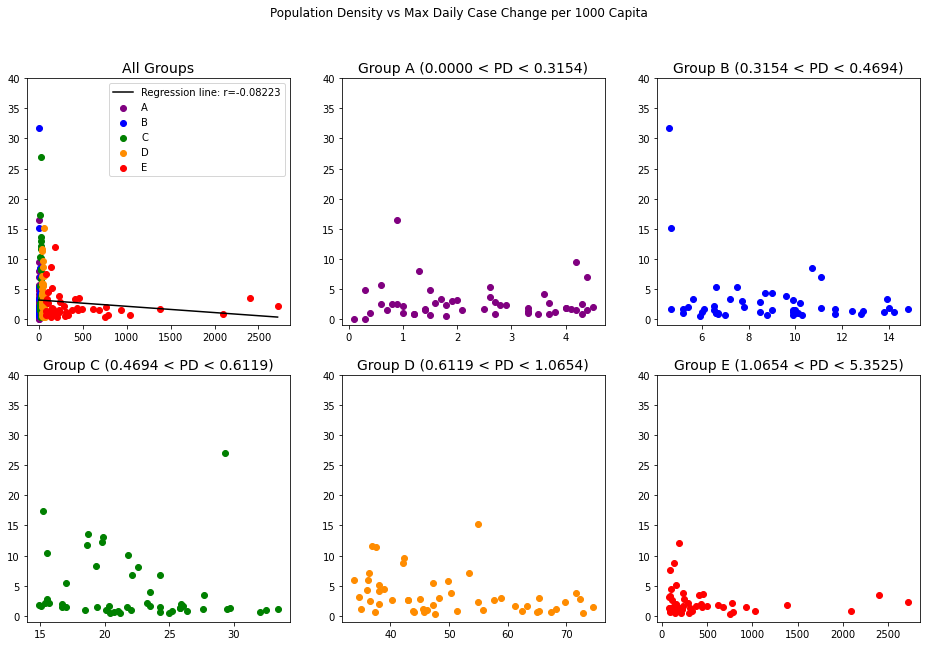

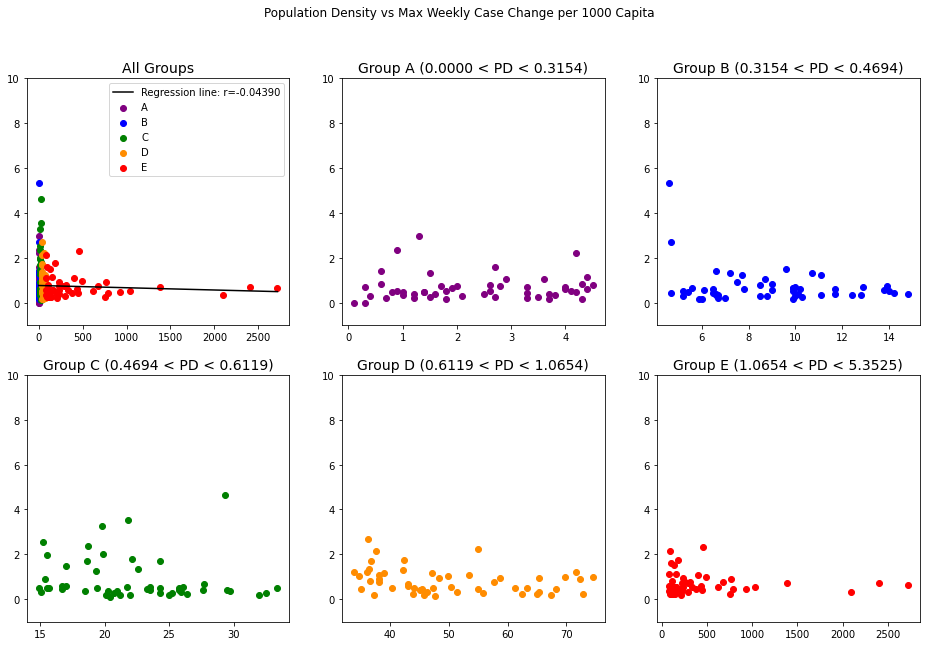

In [21]:
AGroup = dfcounties.loc[dfcounties['Class']=='A']
BGroup = dfcounties.loc[dfcounties['Class']=='B']
CGroup = dfcounties.loc[dfcounties['Class']=='C']
DGroup = dfcounties.loc[dfcounties['Class']=='D']
EGroup = dfcounties.loc[dfcounties['Class']=='E']

def scattergraph(title, yaxis, casedata):
  fig, ax = plt.subplots(2, 3, figsize=(16,10))
  fig.suptitle(title)

  ax[0,0].title.set_text('All Groups')
  ax[0,0].title.set_fontsize(14)
  ax[0,0].set_ylim(yaxis)
  ax[0,0].scatter(AGroup['PD'], AGroup[casedata], color='purple', label='A')
  ax[0,0].scatter(BGroup['PD'], BGroup[casedata], color='blue', label='B')
  ax[0,0].scatter(CGroup['PD'], CGroup[casedata], color='green', label='C')
  ax[0,0].scatter(DGroup['PD'], DGroup[casedata], color='darkorange', label='D')
  ax[0,0].scatter(EGroup['PD'], EGroup[casedata], color='red', label='E')
  slope, intercept, r, p, stderr = linregress(dfcounties['PD'], dfcounties[casedata])
  line = f'Regression line: r={r:.5f}'
  ax[0,0].plot(dfcounties['PD'], intercept + slope * dfcounties['PD'], color='black', label=line)  
  ax[0,0].legend(facecolor='white')

  ax[0,1].title.set_text('Group A ({:2.4f} < PD < {:2.4f})'.format(binedges[0], binedges[1]))
  ax[0,1].title.set_fontsize(14)
  ax[0,1].set_ylim(yaxis)
  ax[0,1].scatter(AGroup['PD'], AGroup[casedata], color='purple')

  ax[0,2].title.set_text('Group B ({:2.4f} < PD < {:2.4f})'.format(binedges[1], binedges[2]))
  ax[0,2].title.set_fontsize(14)
  ax[0,2].set_ylim(yaxis)
  ax[0,2].scatter(BGroup['PD'], BGroup[casedata], color='blue')

  ax[1,0].title.set_text('Group C ({:2.4f} < PD < {:2.4f})'.format(binedges[2], binedges[3]))
  ax[1,0].title.set_fontsize(14)
  ax[1,0].set_ylim(yaxis)
  ax[1,0].scatter(CGroup['PD'], CGroup[casedata], color='green')

  ax[1,1].title.set_text('Group D ({:2.4f} < PD < {:2.4f})'.format(binedges[3], binedges[4]))
  ax[1,1].title.set_fontsize(14)
  ax[1,1].set_ylim(yaxis)
  ax[1,1].scatter(DGroup['PD'], DGroup[casedata], color='darkorange')

  ax[1,2].title.set_text('Group E ({:2.4f} < PD < {:2.4f})'.format(binedges[4], binedges[5]))
  ax[1,2].title.set_fontsize(14)
  ax[1,2].set_ylim(yaxis)
  ax[1,2].scatter(EGroup['PD'], EGroup[casedata], color='red')

  return fig

figure = scattergraph('Population Density vs Total Cases per 1000 Capita', [-10,80], 'total')
#figure.savefig('PDvTC.png')
figure = scattergraph('Population Density vs Mean Daily Case Change per 1000 Capita', [-0.1,0.5], 'dmean')
#figure.savefig('PDvDM.png')
figure = scattergraph('Population Density vs Mean Weekly Case Change per 1000 Capita', [-0.1,0.5], 'wmean')
#figure.savefig('PDvWM.png')
figure = scattergraph('Population Density vs Max Daily Case Change per 1000 Capita', [-1,40], 'dmax')
#figure.savefig('PDvDX.png')
figure = scattergraph('Population Density vs Max Weekly Case Change per 1000 Capita', [-1,10], 'wmax')
#figure.savefig('PDvWX.png')
plt.show()

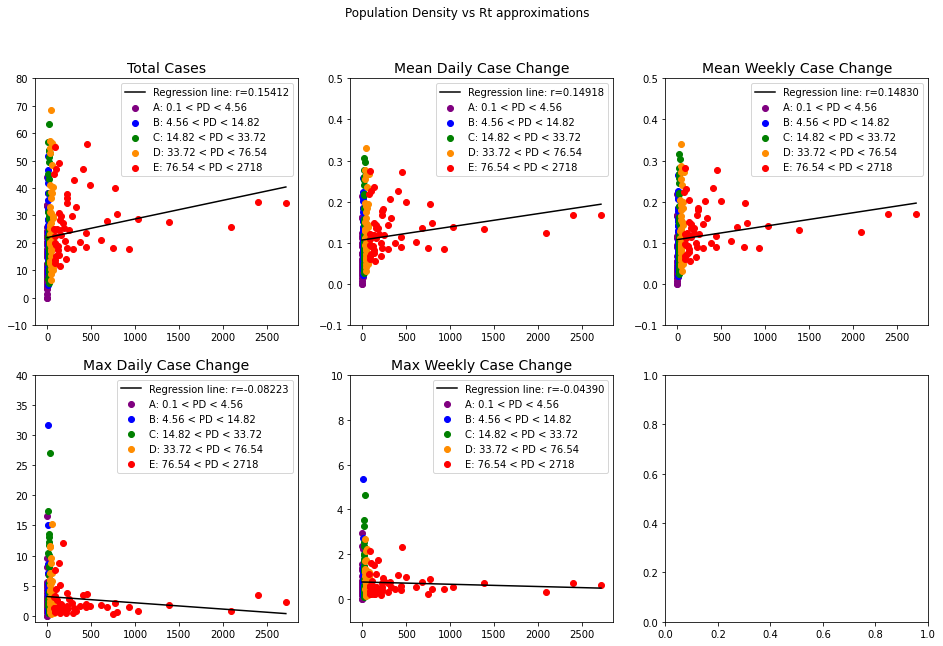

In [22]:
def more_scatter(title, subtitle, yaxis, casedata):  
  fig, ax = plt.subplots(2, 3, figsize=(16,10))
  fig.suptitle(title)
  for i in range(2):
    for j in range(3):
      if (3*i)+j != 5:
        ax[i,j].title.set_text(subtitle[(3*i)+j])
        ax[i,j].title.set_fontsize(14)
        ax[i,j].set_ylim(yaxis[(3*i)+j])
        ax[i,j].scatter(AGroup['PD'], AGroup[casedata[(3*i)+j]], color='purple', label='A: 0.1 < PD < 4.56')
        ax[i,j].scatter(BGroup['PD'], BGroup[casedata[(3*i)+j]], color='blue', label='B: 4.56 < PD < 14.82')
        ax[i,j].scatter(CGroup['PD'], CGroup[casedata[(3*i)+j]], color='green', label='C: 14.82 < PD < 33.72')
        ax[i,j].scatter(DGroup['PD'], DGroup[casedata[(3*i)+j]], color='darkorange', label='D: 33.72 < PD < 76.54')
        ax[i,j].scatter(EGroup['PD'], EGroup[casedata[(3*i)+j]], color='red', label='E: 76.54 < PD < 2718')
        slope, intercept, r, p, stderr = linregress(dfcounties['PD'], dfcounties[casedata[(3*i)+j]])
        line = f'Regression line: r={r:.5f}'
        ax[i,j].plot(dfcounties['PD'], intercept + slope * dfcounties['PD'], color='black', label=line)  
        ax[i,j].legend(facecolor='white')
  return fig

figure = more_scatter('Population Density vs Rt approximations', ['Total Cases', 'Mean Daily Case Change', 'Mean Weekly Case Change', 'Max Daily Case Change', 'Max Weekly Case Change'], [[-10,80], [-0.1,0.5], [-0.1,0.5], [-1,40], [-1,10]], ['total', 'dmean', 'wmean', 'dmax', 'wmax'])
figure.savefig('allapproximations.png')

## Pearson Correlation Test
5 pearson correlation tests were performed. The tests were performed between the 5 ROT assumputions and PD.
  - PD vs Total Cases
  - PD vs Mean Daily Case Change
  - PD vs Mean Weekly Case Change
  - PD vs Max Daily Case Change
  - PD vs Max Weekly Case Change

In [23]:
pearson_result_totalcases = pearsonr(dfcounties['PD'], dfcounties['total'])

print("Population Density and Total Cases per 1000 Capita:")
print("\tPearson Coefficient: {:.5f}, P-Value: {:.6f}\n".format(pearson_result_totalcases[0], pearson_result_totalcases[1]))

pearson_result_dmax = pearsonr(dfcounties['PD'], dfcounties['dmax'])

print("Population Density and Max Daily Case Change per 1000 Capita:")
print("\tPearson Coefficient: {:.5f}, P-Value: {:.6f}\n".format(pearson_result_dmax[0], pearson_result_dmax[1]))

pearson_result_wmax = pearsonr(dfcounties['PD'], dfcounties['wmax'])

print("Population Density and Max Weekly Case Change per 1000 Capita:")
print("\tPearson Coefficient: {:.5f}, P-Value: {:.6f}\n".format(pearson_result_wmax[0], pearson_result_wmax[1]))

pearson_result_dmean = pearsonr(dfcounties['PD'], dfcounties['dmean'])

print("Population Density and Mean Daily Case Change per 1000 Capita:")
print("\tPearson Coefficient: {:.5f}, P-Value: {:.6f}\n".format(pearson_result_dmean[0], pearson_result_dmean[1]))

pearson_result_wmean = pearsonr(dfcounties['PD'], dfcounties['wmean'])

print("Population Density and Mean Weekly Case Change per 1000 Capita:")
print("\tPearson Coefficient: {:.5f}, P-Value: {:.6f}\n".format(pearson_result_wmean[0], pearson_result_wmean[1]))

Population Density and Total Cases per 1000 Capita:
	Pearson Coefficient: 0.15412, P-Value: 0.013939

Population Density and Max Daily Case Change per 1000 Capita:
	Pearson Coefficient: -0.08223, P-Value: 0.191481

Population Density and Max Weekly Case Change per 1000 Capita:
	Pearson Coefficient: -0.04390, P-Value: 0.486069

Population Density and Mean Daily Case Change per 1000 Capita:
	Pearson Coefficient: 0.14918, P-Value: 0.017351

Population Density and Mean Weekly Case Change per 1000 Capita:
	Pearson Coefficient: 0.14830, P-Value: 0.018031



## Creating Choropleth Plots 
6 choropleth plots were created. They are based on:
  - PD
  - Total Cases
  - Mean Daily Case Change
  - Mean Weekly Case Change
  - Max Daily Case Change
  - Max Weekly Case Change

To create the choropleth plots, bins of the plotted variable were created. The bins are based on the ntile = [0, 0.2, 0.4, 0.6, 0.8, 1] for a total of 5 bins. The county are then sorted into their respective bins.

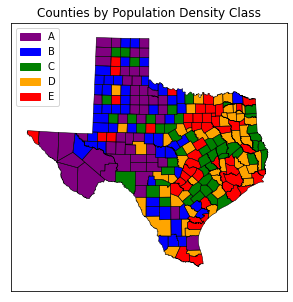

In [24]:
PDcolors = [(128 / 255, 0 / 255, 128 / 255),
            (0 / 255, 0 / 255, 255 / 255), 
            (0 / 255, 128 / 255, 0 / 255),
            (255 / 255, 165 / 255, 0 / 255),
            (255 / 255, 0 / 255, 0 / 255), ]

PDmap = {"A" : 0, "B" : 1, "C" : 2, "D" : 3, "E" : 4, }

#defining a function that will create a choropleth
def choropleth(title, dataclass, colorscheme, classmapping):
  colors = colorscheme

  class2idx = classmapping

  # Lat, lon bounds
  lllon = -107
  urlon = -92
  lllat = 24.5
  urlat = 37
  # Centerpoint
  centerlon = float(lllon + urlon) / 2.0
  centerlat = float(lllat + urlat) / 2.0

  # Init basemap with projection, bounds
  m = Basemap(resolution = 'i',
              llcrnrlon = lllon, urcrnrlon = urlon,
              lon_0 = centerlon,
              llcrnrlat = lllat, urcrnrlat = urlat,
              lat_0 = centerlat,
              projection='tmerc')

  # Read county boundaries
  shp_info = m.readshapefile('County', 'counties', drawbounds = True)

  plt.title(title)
  plt.tight_layout(pad = 0, w_pad = 0, h_pad = 0)

  ax = plt.gca()
  index = dfcounties.index
  for i, county in enumerate(m.counties_info):
    name = county["CNTY_NM"]
    if name == "De Witt":
      name = "dewitt"
    try:
      label = dfcounties[index == name.lower()][dataclass].values[0]
    except:
      print(name)
    idx = class2idx[label]
    color = colors[idx]

    countyseg = m.counties[i]
    poly = Polygon(countyseg, facecolor = color)  # edgecolor="white"
    ax.add_patch(poly)

  patches = [
              mpatches.Patch(color = colors[0], label = "A", linestyle = "solid"),
              mpatches.Patch(color = colors[1], label = "B", linestyle = "solid"),
              mpatches.Patch(color = colors[2], label = "C", linestyle = "solid"),
              mpatches.Patch(color = colors[3], label = "D", linestyle = "solid"),
              mpatches.Patch(color = colors[4], label = "E", linestyle = "solid"),
  ]
  ax.legend(loc = "upper left", handles = patches)

choropleth('Counties by Population Density Class', "Class", PDcolors, PDmap)

[ 0.         11.89395818 16.86649326 22.87303593 32.45984028 68.41387445]


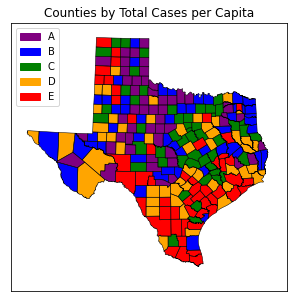

In [25]:
grouping = [0,0.2,0.4,0.6,0.8,1]
classlabels = ['A', 'B', 'C', 'D', 'E']

bins, binedges = pd.qcut(dfcounties['total'],q=grouping, labels=classlabels, retbins=True)
print(binedges)
dfcounties['tclass'] = bins

choropleth('Counties by Total Cases per Capita', "tclass", PDcolors, PDmap)

[0.         0.05752693 0.08309713 0.1105439  0.15723235 0.33050181]


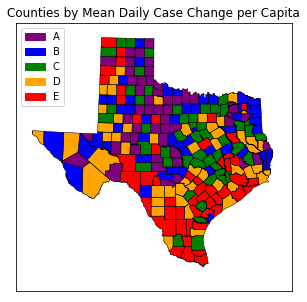

In [26]:
grouping = [0,0.2,0.4,0.6,0.8,1]
classlabels = ['A', 'B', 'C', 'D', 'E']

bins, binedges = pd.qcut(dfcounties['dmean'],q=grouping, labels=classlabels, retbins=True)
print(binedges)
dfcounties['dmclass'] = bins

choropleth('Counties by Mean Daily Case Change per Capita', "dmclass", PDcolors, PDmap)

[ 0.          0.93027404  1.51082395  2.1336712   3.82223619 31.65843741]


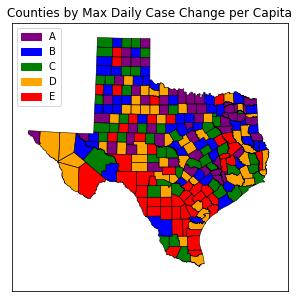

In [27]:
grouping = [0,0.2,0.4,0.6,0.8,1]
classlabels = ['A', 'B', 'C', 'D', 'E']

bins, binedges = pd.qcut(dfcounties['dmax'],q=grouping, labels=classlabels, retbins=True)
print(binedges)
dfcounties['dxclass'] = bins

choropleth('Counties by Max Daily Case Change per Capita', "dxclass", PDcolors, PDmap)

[0.         0.05765685 0.08393146 0.11168838 0.16028679 0.3393982 ]


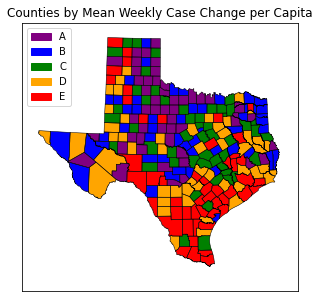

In [28]:
grouping = [0,0.2,0.4,0.6,0.8,1]
classlabels = ['A', 'B', 'C', 'D', 'E']

bins, binedges = pd.qcut(dfcounties['wmean'],q=grouping, labels=classlabels, retbins=True)
print(binedges)
dfcounties['wmclass'] = bins

choropleth('Counties by Mean Weekly Case Change per Capita', "wmclass", PDcolors, PDmap)

[0.         0.31536579 0.46936635 0.61190765 1.06544908 5.352475  ]


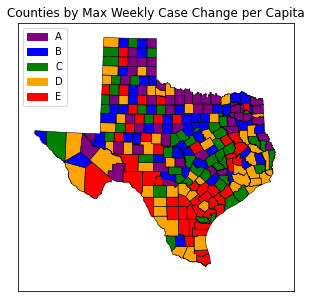

In [29]:
grouping = [0,0.2,0.4,0.6,0.8,1]
classlabels = ['A', 'B', 'C', 'D', 'E']

bins, binedges = pd.qcut(dfcounties['wmax'],q=grouping, labels=classlabels, retbins=True)
print(binedges)
dfcounties['wxclass'] = bins

choropleth('Counties by Max Weekly Case Change per Capita', "wxclass", PDcolors, PDmap)

## Extra
I performed a T-Test on AGroup and EGroup, but I am not certain how to interpret the results. This tests show that there is a significant difference between the distributions of total cases between Group A and Group E. The Pearson Correlation Test is probably a better for this hypothesis. 

In [30]:
from scipy.stats import ttest_ind

print(AGroup.describe())
print(EGroup.describe())

ttest, p = ttest_ind(AGroup['total'], EGroup['total'])
print('Total Cases Comparison between A and E PD groups')
print('P-Value: {}'.format(p))

              PD           POP      total  ...       dmax      wmean       wmax
count  51.000000     51.000000  51.000000  ...  51.000000  51.000000  51.000000
mean    2.341176   3090.725490  14.857992  ...   2.732749   0.072147   0.674360
std     1.367944   2555.129148  10.099688  ...   2.762968   0.049493   0.580488
min     0.100000     82.000000   0.000000  ...   0.000000   0.000000   0.000000
25%     1.200000   1497.500000   7.389481  ...   1.134694   0.036470   0.320720
50%     2.100000   3057.000000  12.229016  ...   1.918772   0.061637   0.523606
75%     3.650000   3719.000000  20.403551  ...   2.929085   0.099201   0.780776
max     4.500000  15507.000000  44.097876  ...  16.483516   0.219392   2.957784

[8 rows x 7 columns]
                PD           POP      total  ...       dmax      wmean       wmax
count    51.000000  5.100000e+01  51.000000  ...  51.000000  51.000000  51.000000
mean    438.929412  4.159136e+05  27.962464  ...   2.178162   0.136548   0.691527
std     573.